In [13]:
pip install torch==0.4.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install torchaudio

  Using cached torch-1.6.0-cp36-cp36m-manylinux1_x86_64.whl (748.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch
#import torchaudio
print(torch.__version__)
print(torch.cuda.is_available())
#print(torchaudio.__version__)

0.4.1
True


In [22]:
!nvidia-smi


Wed Sep 23 22:27:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P2    37W / 180W |    955MiB /  8116MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# utils.py:

In [23]:
import torch
#import torchaudio
print(torch.__version__)
#print(torchaudio.__version__)

0.4.1


In [24]:
# Created on 2018/12
# Author: Kaituo XU

import math

import torch


def overlap_and_add(signal, frame_step):
    """Reconstructs a signal from a framed representation.

    Adds potentially overlapping frames of a signal with shape
    `[..., frames, frame_length]`, offsetting subsequent frames by `frame_step`.
    The resulting tensor has shape `[..., output_size]` where

        output_size = (frames - 1) * frame_step + frame_length

    Args:
        signal: A [..., frames, frame_length] Tensor. All dimensions may be unknown, and rank must be at least 2.
        frame_step: An integer denoting overlap offsets. Must be less than or equal to frame_length.

    Returns:
        A Tensor with shape [..., output_size] containing the overlap-added frames of signal's inner-most two dimensions.
        output_size = (frames - 1) * frame_step + frame_length

    Based on https://github.com/tensorflow/tensorflow/blob/r1.12/tensorflow/contrib/signal/python/ops/reconstruction_ops.py
    """
    outer_dimensions = signal.size()[:-2]
    frames, frame_length = signal.size()[-2:]

    subframe_length = math.gcd(frame_length, frame_step)  # gcd=Greatest Common Divisor
    subframe_step = frame_step // subframe_length
    subframes_per_frame = frame_length // subframe_length
    output_size = frame_step * (frames - 1) + frame_length
    output_subframes = output_size // subframe_length

    subframe_signal = signal.view(*outer_dimensions, -1, subframe_length)

    frame = torch.arange(0, output_subframes).unfold(0, subframes_per_frame, subframe_step)
    frame = signal.new_tensor(frame).long()  # signal may in GPU or CPU
    frame = frame.contiguous().view(-1)

    result = signal.new_zeros(*outer_dimensions, output_subframes, subframe_length)
    result.index_add_(-2, frame, subframe_signal)
    result = result.view(*outer_dimensions, -1)
    return result


def remove_pad(inputs, inputs_lengths):
    """
    Args:
        inputs: torch.Tensor, [B, C, T] or [B, T], B is batch size
        inputs_lengths: torch.Tensor, [B]
    Returns:
        results: a list containing B items, each item is [C, T], T varies
    """
    results = []
    dim = inputs.dim()
    if dim == 3:
        C = inputs.size(1)
    for input, length in zip(inputs, inputs_lengths):
        if dim == 3: # [B, C, T]
            results.append(input[:,:length].view(C, -1).cpu().numpy())
        elif dim == 2:  # [B, T]
            results.append(input[:length].view(-1).cpu().numpy())
    return results

#%%
if __name__ == '__main__':
    torch.manual_seed(123)
    M, C, K, N = 2, 2, 3, 4
    frame_step = 2
    signal = torch.randint(5, (M, C, K, N))
    result = overlap_and_add(signal, frame_step)
    print(signal)
    print(result)


tensor([[[[2., 4., 2., 0.],
          [0., 2., 1., 2.],
          [4., 4., 1., 1.]],

         [[1., 1., 2., 4.],
          [4., 1., 3., 0.],
          [0., 1., 0., 2.]]],


        [[[4., 2., 1., 1.],
          [0., 1., 1., 0.],
          [3., 4., 4., 1.]],

         [[1., 3., 0., 0.],
          [4., 1., 1., 2.],
          [3., 1., 2., 2.]]]])
tensor([[[2., 4., 2., 2., 5., 6., 1., 1.],
         [1., 1., 6., 5., 3., 1., 0., 2.]],

        [[4., 2., 1., 2., 4., 4., 4., 1.],
         [1., 3., 4., 1., 4., 3., 2., 2.]]])


# conv_tasnet.py:

mixture tensor([[1., 1., 0., 0., 1., 2., 0., 2., 2., 1., 2., 1.],
        [0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.]])
U Parameter containing:
tensor([[[1., 0., 0., 1.]],

        [[0., 1., 0., 1.]],

        [[1., 1., 0., 0.]]], requires_grad=True)
mixture_w tensor([[[1., 2., 3., 1., 3.],
         [1., 2., 4., 3., 2.],
         [2., 0., 3., 2., 3.]],

        [[0., 1., 1., 2., 1.],
         [1., 0., 1., 2., 1.],
         [1., 1., 0., 2., 2.]]], grad_fn=<ReluBackward>)
mixture_w size torch.Size([2, 3, 5])
est_mask tensor([[[[0.1345, 0.0000, 0.0000, 0.0486, 0.0000],
          [0.0000, 0.0000, 0.4120, 0.0000, 0.0099],
          [1.2053, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[1.3484, 0.0000, 0.0000, 0.5841, 0.0000],
          [0.0000, 0.0000, 0.4588, 0.0000, 0.0332],
          [0.9679, 0.0000, 0.0150, 0.0000, 0.0000]]],


        [[[0.0245, 0.1034, 0.0254, 0.0332, 0.0556],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.8334, 0.0422, 0.0000, 0.7139]],

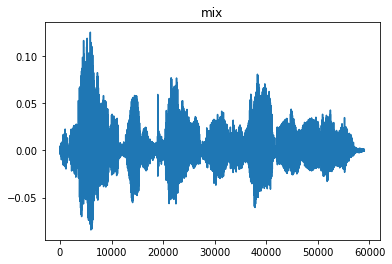

In [25]:
# Created on 2018/12
# Author: Kaituo XU

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import overlap_and_add

EPS = 1e-8


class ConvTasNet(nn.Module):
    def __init__(self, N, L, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            L: Length of the filters (in samples)
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(ConvTasNet, self).__init__()
        # Hyper-parameter
        self.N, self.L, self.B, self.H, self.P, self.X, self.R, self.C = N, L, B, H, P, X, R, C
        self.norm_type = norm_type
        self.causal = causal
        self.mask_nonlinear = mask_nonlinear
        # Components
        self.encoder = Encoder(L, N)
        self.separator = TemporalConvNet(N, B, H, P, X, R, C, norm_type, causal, mask_nonlinear)
        self.decoder = Decoder(N, L)
        # init
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            est_source: [M, C, T]
        """
        mixture_w = self.encoder(mixture)
        est_mask = self.separator(mixture_w)
        est_source = self.decoder(mixture_w, est_mask)

        # T changed after conv1d in encoder, fix it here
        T_origin = mixture.size(-1)
        T_conv = est_source.size(-1)
        est_source = F.pad(est_source, (0, T_origin - T_conv))
        return est_source

    @classmethod
    def load_model(cls, path):
        # Load to CPU
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = cls.load_model_from_package(package)
        return model

    @classmethod
    def load_model_from_package(cls, package):
        model = cls(package['N'], package['L'], package['B'], package['H'],
                    package['P'], package['X'], package['R'], package['C'],
                    norm_type=package['norm_type'], causal=package['causal'],
                    mask_nonlinear=package['mask_nonlinear'])
        model.load_state_dict(package['state_dict'])
        return model

    @staticmethod
    def serialize(model, optimizer, epoch, tr_loss=None, cv_loss=None):
        package = {
            # hyper-parameter
            'N': model.N, 'L': model.L, 'B': model.B, 'H': model.H,
            'P': model.P, 'X': model.X, 'R': model.R, 'C': model.C,
            'norm_type': model.norm_type, 'causal': model.causal,
            'mask_nonlinear': model.mask_nonlinear,
            # state
            'state_dict': model.state_dict(),
            'optim_dict': optimizer.state_dict(),
            'epoch': epoch
        }
        if tr_loss is not None:
            package['tr_loss'] = tr_loss
            package['cv_loss'] = cv_loss
        return package


class Encoder(nn.Module):
    """Estimation of the nonnegative mixture weight by a 1-D conv layer.
    """
    def __init__(self, L, N):
        super(Encoder, self).__init__()
        # Hyper-parameter
        self.L, self.N = L, N
        # Components
        # 50% overlap
        self.conv1d_U = nn.Conv1d(1, N, kernel_size=L, stride=L // 2, bias=False)

    def forward(self, mixture):
        """
        Args:
            mixture: [M, T], M is batch size, T is #samples
        Returns:
            mixture_w: [M, N, K], where K = (T-L)/(L/2)+1 = 2T/L-1
        """
        mixture = torch.unsqueeze(mixture, 1)  # [M, 1, T]
        mixture_w = F.relu(self.conv1d_U(mixture))  # [M, N, K]
        return mixture_w


class Decoder(nn.Module):
    def __init__(self, N, L):
        super(Decoder, self).__init__()
        # Hyper-parameter
        self.N, self.L = N, L
        # Components
        self.basis_signals = nn.Linear(N, L, bias=False)

    def forward(self, mixture_w, est_mask):
        """
        Args:
            mixture_w: [M, N, K]
            est_mask: [M, C, N, K]
        Returns:
            est_source: [M, C, T]
        """
        # D = W * M
        #fatemeh: size(torch.unsqueeze()):torch.Size([2, 1, 3, 5]) , size(est_mask):torch.Size([2, 5, 2, 3])
        source_w = torch.unsqueeze(mixture_w, 1) * est_mask  # [M, C, N, K]
        source_w = torch.transpose(source_w, 2, 3) # [M, C, K, N]
        # S = DV
        est_source = self.basis_signals(source_w)  # [M, C, K, L]
        est_source = overlap_and_add(est_source, self.L//2) # M x C x T
        return est_source


class TemporalConvNet(nn.Module):
    def __init__(self, N, B, H, P, X, R, C, norm_type="gLN", causal=False,
                 mask_nonlinear='relu'):
        """
        Args:
            N: Number of filters in autoencoder
            B: Number of channels in bottleneck 1 × 1-conv block
            H: Number of channels in convolutional blocks
            P: Kernel size in convolutional blocks
            X: Number of convolutional blocks in each repeat
            R: Number of repeats
            C: Number of speakers
            norm_type: BN, gLN, cLN
            causal: causal or non-causal
            mask_nonlinear: use which non-linear function to generate mask
        """
        super(TemporalConvNet, self).__init__()
        # Hyper-parameter
        self.C = C
        self.mask_nonlinear = mask_nonlinear
        # Components
        # [M, N, K] -> [M, N, K]
        layer_norm = ChannelwiseLayerNorm(N)
        # [M, N, K] -> [M, B, K]
        bottleneck_conv1x1 = nn.Conv1d(N, B, 1, bias=False)
        # [M, B, K] -> [M, B, K]
        repeats = []
        for r in range(R):
            blocks = []
            for x in range(X):
                dilation = 2**x
                padding = (P - 1) * dilation if causal else (P - 1) * dilation // 2
                blocks += [TemporalBlock(B, H, P, stride=1,
                                         padding=padding,
                                         dilation=dilation,
                                         norm_type=norm_type,
                                         causal=causal)]
            repeats += [nn.Sequential(*blocks)]
        temporal_conv_net = nn.Sequential(*repeats)
        # [M, B, K] -> [M, C*N, K]
        mask_conv1x1 = nn.Conv1d(B, C*N, 1, bias=False)
        # Put together
        self.network = nn.Sequential(layer_norm,
                                     bottleneck_conv1x1,
                                     temporal_conv_net,
                                     mask_conv1x1)

    def forward(self, mixture_w):
        """
        Keep this API same with TasNet
        Args:
            mixture_w: [M, N, K], M is batch size
        returns:
            est_mask: [M, C, N, K]
        """
        M, N, K = mixture_w.size()
        score = self.network(mixture_w)  # [M, N, K] -> [M, C*N, K]
        score = score.view(M, self.C, N, K) # [M, C*N, K] -> [M, C, N, K]
        if self.mask_nonlinear == 'softmax':
            est_mask = F.softmax(score, dim=1)
        elif self.mask_nonlinear == 'relu':
            est_mask = F.relu(score)
        else:
            raise ValueError("Unsupported mask non-linear function")
        return est_mask


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation, norm_type="gLN", causal=False):
        super(TemporalBlock, self).__init__()
        # [M, B, K] -> [M, H, K]
        conv1x1 = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        prelu = nn.PReLU()
        norm = chose_norm(norm_type, out_channels)
        # [M, H, K] -> [M, B, K]
        dsconv = DepthwiseSeparableConv(out_channels, in_channels, kernel_size,
                                        stride, padding, dilation, norm_type,
                                        causal)
        # Put together
        self.net = nn.Sequential(conv1x1, prelu, norm, dsconv)

    def forward(self, x):
        """
        Args:
            x: [M, B, K]
        Returns:
            [M, B, K]
        """
        residual = x
        out = self.net(x)
        # TODO: when P = 3 here works fine, but when P = 2 maybe need to pad?
        return out + residual  # look like w/o F.relu is better than w/ F.relu
        # return F.relu(out + residual)


class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, dilation, norm_type="gLN", causal=False):
        super(DepthwiseSeparableConv, self).__init__()
        # Use `groups` option to implement depthwise convolution
        # [M, H, K] -> [M, H, K]
        depthwise_conv = nn.Conv1d(in_channels, in_channels, kernel_size,
                                   stride=stride, padding=padding,
                                   dilation=dilation, groups=in_channels,
                                   bias=False)
        if causal:
            chomp = Chomp1d(padding)
        prelu = nn.PReLU()
        norm = chose_norm(norm_type, in_channels)
        # [M, H, K] -> [M, B, K]
        pointwise_conv = nn.Conv1d(in_channels, out_channels, 1, bias=False)
        # Put together
        if causal:
            self.net = nn.Sequential(depthwise_conv, chomp, prelu, norm,
                                     pointwise_conv)
        else:
            self.net = nn.Sequential(depthwise_conv, prelu, norm,
                                     pointwise_conv)

    def forward(self, x):
        """
        Args:
            x: [M, H, K]
        Returns:
            result: [M, B, K]
        """
        return self.net(x)


class Chomp1d(nn.Module):
    """To ensure the output length is the same as the input.
    """
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        Args:
            x: [M, H, Kpad]
        Returns:
            [M, H, K]
        """
        return x[:, :, :-self.chomp_size].contiguous()


def chose_norm(norm_type, channel_size):
    """The input of normlization will be (M, C, K), where M is batch size,
       C is channel size and K is sequence length.
    """
    if norm_type == "gLN":
        return GlobalLayerNorm(channel_size)
    elif norm_type == "cLN":
        return ChannelwiseLayerNorm(channel_size)
    else: # norm_type == "BN":
        # Given input (M, C, K), nn.BatchNorm1d(C) will accumulate statics
        # along M and K, so this BN usage is right.
        return nn.BatchNorm1d(channel_size)


# TODO: Use nn.LayerNorm to impl cLN to speed up
class ChannelwiseLayerNorm(nn.Module):
    """Channel-wise Layer Normalization (cLN)"""
    def __init__(self, channel_size):
        super(ChannelwiseLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(1, channel_size, 1))  # [1, N, 1]
        self.beta = nn.Parameter(torch.Tensor(1, channel_size,1 ))  # [1, N, 1]
        self.reset_parameters()

    def reset_parameters(self):
        self.gamma.data.fill_(1)
        self.beta.data.zero_()

    def forward(self, y):
        """
        Args:
            y: [M, N, K], M is batch size, N is channel size, K is length
        Returns:
            cLN_y: [M, N, K]
        """
        #fatemeh : set float
        y=y.float()
        mean = torch.mean(y, dim=1, keepdim=True)  # [M, 1, K]
        var = torch.var(y, dim=1, keepdim=True, unbiased=False)  # [M, 1, K]
        cLN_y = self.gamma * (y - mean) / torch.pow(var + EPS, 0.5) + self.beta
        return cLN_y


class GlobalLayerNorm(nn.Module):
    """Global Layer Normalization (gLN)"""
    def __init__(self, channel_size):
        super(GlobalLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.Tensor(1, channel_size, 1))  # [1, N, 1]
        self.beta = nn.Parameter(torch.Tensor(1, channel_size,1 ))  # [1, N, 1]
        self.reset_parameters()

    def reset_parameters(self):
        self.gamma.data.fill_(1)
        self.beta.data.zero_()

    def forward(self, y):
        """
        Args:
            y: [M, N, K], M is batch size, N is channel size, K is length
        Returns:
            gLN_y: [M, N, K]
        """
        # TODO: in torch 1.0, torch.mean() support dim list
        mean = y.mean(dim=1, keepdim=True).mean(dim=2, keepdim=True) #[M, 1, 1]
        var = (torch.pow(y-mean, 2)).mean(dim=1, keepdim=True).mean(dim=2, keepdim=True)
        gLN_y = self.gamma * (y - mean) / torch.pow(var + EPS, 0.5) + self.beta
        return gLN_y
#%%

if __name__ == "__main__":
    torch.manual_seed(123)
    M, N, L, T = 2, 3, 4, 12
    #K = (T-L)/(L/2)+1
    K = 2*T//L-1
    B, H, P, X, R, C, norm_type, causal = 2, 3, 3, 3, 2, 2, "gLN", False
    mixture = torch.randint(3, (M, T))
#%%
    # test Encoder
    encoder = Encoder(L, N)
    encoder.conv1d_U.weight.data = torch.randint(2, encoder.conv1d_U.weight.size())
    mixture_w = encoder(mixture)
    print('mixture', mixture)
    print('U', encoder.conv1d_U.weight)
    print('mixture_w', mixture_w)
    print('mixture_w size', mixture_w.size())
#%%
    # test TemporalConvNet
    separator = TemporalConvNet(N, B, H, P, X, R, C, norm_type=norm_type, causal=causal)
    est_mask = separator(mixture_w)
    print('est_mask', est_mask)
#%%
    #fatemeh:error!!!with est_mask
    # test Decoder
    decoder = Decoder(N, L)
    #est_mask = torch.randint(2, (B, K, C, N))
    est_source = decoder(mixture_w, est_mask)
    print('est_source', est_source)

#%%
    
    #fatemeh: I put a mixture x as input instead of randint for mixture above
    # test Conv-TasNet
    import os
    
    audio_path='/home/speech/f_torch/bin/data/tr/mix/mix12_ff.wav'
    import librosa
    data, sr = librosa.load(audio_path)
    x = torch.from_numpy(data)
    mixture=x
    x=x.reshape(2,len(mixture)//2)
    
    conv_tasnet = ConvTasNet(N, L, B, H, P, X, R, C, norm_type=norm_type)
    est_source = conv_tasnet(x)
    print('est_source', est_source)
    print('est_source size', est_source.size())
#%%
    import matplotlib.pyplot as plt
    import librosa
    import numpy
    mix_audio_path='/home/speech/f_torch/bin/data/tr/mix/mix12_ff.wav'
    data, sr = librosa.load(mix_audio_path)
    plt.figure()
    plt.plot(data)
    plt.title('mix')

    import numpy as np
    import soundfile as sf
#data, sr = librosa.load(mix_audio_path)
    d=est_source.detach().numpy()
    samplerate=sr
#rate = 44100
#data = np.random.uniform(-1, 1, size=(rate * 10, 2))
    s_path='est_source.wav'
# Write out audio as 24bit PCM WAV

#data, sr = librosa.load(s_path)
#plt.figure()
#plt.plot(data)
#plt.title('s')



# preprocess.py:

In [26]:
torch.cuda.is_available()

True

In [27]:
#!/usr/bin/env python
# Created on 2018/12
# Author: Kaituo XU

#import argparse
import json
import os

import librosa


def preprocess_one_dir(in_dir, out_dir, out_filename, sample_rate=16000):
    file_infos = []
    in_dir = os.path.abspath(in_dir)
    wav_list = os.listdir(in_dir)
    for wav_file in wav_list:
        if not wav_file.endswith('.wav'):
            continue
        wav_path = os.path.join(in_dir, wav_file)
        samples, _ = librosa.load(wav_path, sr=sample_rate)
        file_infos.append((wav_path, len(samples)))
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    with open(os.path.join(out_dir, out_filename + '.json'), 'w') as f:
        json.dump(file_infos, f, indent=4)




#fatemeh#def preprocess(args):
  #fatemeh#  for data_type in ['tr', 'cv', 'tt']:
  #fatemeh#      for speaker in ['mix', 's1', 's2']:
  #fatemeh#          preprocess_one_dir(os.path.join(args.in_dir, data_type, speaker),
  #fatemeh#                             os.path.join(args.out_dir, data_type),
  #fatemeh#                             speaker,
  #fatemeh#                             sample_rate=args.sample_rate)
            
#fatemeh delete args
def preprocess(in_dir,out_dir,sample_rate):
    for data_type in ['tr', 'cv', 'tt']:
        for speaker in ['mix', 's1', 's2']:
            preprocess_one_dir(os.path.join(in_dir, data_type, speaker),
                               os.path.join(out_dir, data_type),
                               speaker,
                               sample_rate=sample_rate)
#%%
if __name__ == "__main__":
    in_dir="/home/speech/f_torch/bin/data"

    out_dir="/home/speech/f_torch/bin/outdata"
    sample_rate=16000
    preprocess(in_dir,out_dir,sample_rate)
    #fatemeh#parser = argparse.ArgumentParser("WSJ0 data preprocessing")
    #fatemeh#parser.add_argument('--in-dir', type=str, default=None,
    #fatemeh#                    help='Directory path of wsj0 including tr, cv and tt')
    #fatemeh#parser.add_argument('--out-dir', type=str, default=None,
    #fatemeh#                    help='Directory path to put output files')
    #fatemeh#parser.add_argument('--sample-rate', type=int, default=8000,
    #fatemeh#                    help='Sample rate of audio file')
    #fatemeh#args = parser.parse_args()
    #fatemeh#print(args)
    #fatemeh#preprocess(args)


# data.py:

In [28]:
# Created on 2018/12
# Author: Kaituo XU
"""
Logic:
1. AudioDataLoader generate a minibatch from AudioDataset, the size of this
   minibatch is AudioDataLoader's batchsize. For now, we always set
   AudioDataLoader's batchsize as 1. The real minibatch size we care about is
   set in AudioDataset's __init__(...). So actually, we generate the
   information of one minibatch in AudioDataset.
2. After AudioDataLoader getting one minibatch from AudioDataset,
   AudioDataLoader calls its collate_fn(batch) to process this minibatch.

Input:
    Mixtured WJS0 tr, cv and tt path
Output:
    One batch at a time.
    Each inputs's shape is B x T
    Each targets's shape is B x C x T
"""

import json
import math
import os

import numpy as np
import torch
import torch.utils.data as data

import librosa


class AudioDataset(data.Dataset):

    def __init__(self, json_dir, batch_size, sample_rate=16000, segment=1, cv_maxlen=8.0):
        """
        Args:
            json_dir: directory including mix.json, s1.json and s2.json
            segment: duration of audio segment, when set to -1, use full audio

        xxx_infos is a list and each item is a tuple (wav_file, #samples)
        """
        super(AudioDataset, self).__init__()
        mix_json = os.path.join(json_dir, 'mix.json')
        s1_json = os.path.join(json_dir, 's1.json')
        s2_json = os.path.join(json_dir, 's2.json')
        with open(mix_json, 'r') as f:
            mix_infos = json.load(f)
        with open(s1_json, 'r') as f:
            s1_infos = json.load(f)
        with open(s2_json, 'r') as f:
            s2_infos = json.load(f)
        # sort it by #samples (impl bucket)
        def sort(infos): return sorted(
            infos, key=lambda info: int(info[1]), reverse=True)
        sorted_mix_infos = sort(mix_infos)
        sorted_s1_infos = sort(s1_infos)
        sorted_s2_infos = sort(s2_infos)
        if segment >= 0.0:
            # segment length and count dropped utts
            segment_len = int(segment * sample_rate)  # 4s * 8000/s = 32000 samples
            drop_utt, drop_len = 0, 0
            for _, sample in sorted_mix_infos:
                if sample < segment_len:
                    drop_utt += 1
                    drop_len += sample
            print("Drop {} utts({:.2f} h) which is short than {} samples".format(
                drop_utt, drop_len/sample_rate/36000, segment_len))
            # generate minibach infomations
            minibatch = []
            start = 0
            while True:
                num_segments = 0
                end = start
                part_mix, part_s1, part_s2 = [], [], []
                while num_segments < batch_size and end < len(sorted_mix_infos):
                    utt_len = int(sorted_mix_infos[end][1])
                    if utt_len >= segment_len:  # skip too short utt
                        num_segments += math.ceil(utt_len / segment_len)
                        # Ensure num_segments is less than batch_size
                        if num_segments > batch_size:
                            # if num_segments of 1st audio > batch_size, skip it
                            if start == end: end += 1
                            break
                        part_mix.append(sorted_mix_infos[end])
                        part_s1.append(sorted_s1_infos[end])
                        part_s2.append(sorted_s2_infos[end])
                    end += 1
                if len(part_mix) > 0:
                    minibatch.append([part_mix, part_s1, part_s2,
                                      sample_rate, segment_len])
                if end == len(sorted_mix_infos):
                    break
                start = end
            self.minibatch = minibatch
        else:  # Load full utterance but not segment
            # generate minibach infomations
            minibatch = []
            start = 0
            while True:
                end = min(len(sorted_mix_infos), start + batch_size)
                # Skip long audio to avoid out-of-memory issue
                if int(sorted_mix_infos[start][1]) > cv_maxlen * sample_rate:
                    start = end
                    continue
                minibatch.append([sorted_mix_infos[start:end],
                                  sorted_s1_infos[start:end],
                                  sorted_s2_infos[start:end],
                                  sample_rate, segment])
                if end == len(sorted_mix_infos):
                    break
                start = end
            self.minibatch = minibatch

    def __getitem__(self, index):
        return self.minibatch[index]

    def __len__(self):
        return len(self.minibatch)


class AudioDataLoader(data.DataLoader):
    """
    NOTE: just use batchsize=1 here, so drop_last=True makes no sense here.
    """

    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn


def _collate_fn(batch):
    """
    Args:
        batch: list, len(batch) = 1. See AudioDataset.__getitem__()
    Returns:
        mixtures_pad: B x T, torch.Tensor
        ilens : B, torch.Tentor
        sources_pad: B x C x T, torch.Tensor
    """
    # batch should be located in list
    assert len(batch) == 1
    mixtures, sources = load_mixtures_and_sources(batch[0])

    # get batch of lengths of input sequences
    ilens = np.array([mix.shape[0] for mix in mixtures])

    # perform padding and convert to tensor
    pad_value = 0
    mixtures_pad = pad_list([torch.from_numpy(mix).float()
                             for mix in mixtures], pad_value)
    ilens = torch.from_numpy(ilens)
    sources_pad = pad_list([torch.from_numpy(s).float()
                            for s in sources], pad_value)
    # N x T x C -> N x C x T
    sources_pad = sources_pad.permute((0, 2, 1)).contiguous()
    return mixtures_pad, ilens, sources_pad


# Eval data part
from preprocess import preprocess_one_dir

class EvalDataset(data.Dataset):

    def __init__(self, mix_dir, mix_json, batch_size, sample_rate=16000):
        """
        Args:
            mix_dir: directory including mixture wav files
            mix_json: json file including mixture wav files
        """
        super(EvalDataset, self).__init__()
        assert mix_dir != None or mix_json != None
        if mix_dir is not None:
            # Generate mix.json given mix_dir
            preprocess_one_dir(mix_dir, mix_dir, 'mix',
                               sample_rate=sample_rate)
            mix_json = os.path.join(mix_dir, 'mix.json')
        with open(mix_json, 'r') as f:
            mix_infos = json.load(f)
        # sort it by #samples (impl bucket)
        def sort(infos): return sorted(
            infos, key=lambda info: int(info[1]), reverse=True)
        sorted_mix_infos = sort(mix_infos)
        # generate minibach infomations
        minibatch = []
        start = 0
        while True:
            end = min(len(sorted_mix_infos), start + batch_size)
            minibatch.append([sorted_mix_infos[start:end],
                              sample_rate])
            if end == len(sorted_mix_infos):
                break
            start = end
        self.minibatch = minibatch

    def __getitem__(self, index):
        return self.minibatch[index]

    def __len__(self):
        return len(self.minibatch)


class EvalDataLoader(data.DataLoader):
    """
    NOTE: just use batchsize=1 here, so drop_last=True makes no sense here.
    """

    def __init__(self, *args, **kwargs):
        super(EvalDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn_eval


def _collate_fn_eval(batch):
    """
    Args:
        batch: list, len(batch) = 1. See AudioDataset.__getitem__()
    Returns:
        mixtures_pad: B x T, torch.Tensor
        ilens : B, torch.Tentor
        filenames: a list contain B strings
    """
    # batch should be located in list
    assert len(batch) == 1
    mixtures, filenames = load_mixtures(batch[0])

    # get batch of lengths of input sequences
    ilens = np.array([mix.shape[0] for mix in mixtures])

    # perform padding and convert to tensor
    pad_value = 0
    mixtures_pad = pad_list([torch.from_numpy(mix).float()
                             for mix in mixtures], pad_value)
    ilens = torch.from_numpy(ilens)
    return mixtures_pad, ilens, filenames


# ------------------------------ utils ------------------------------------
def load_mixtures_and_sources(batch):
    """
    Each info include wav path and wav duration.
    Returns:
        mixtures: a list containing B items, each item is T np.ndarray
        sources: a list containing B items, each item is T x C np.ndarray
        T varies from item to item.
    """
    mixtures, sources = [], []
    mix_infos, s1_infos, s2_infos, sample_rate, segment_len = batch
    # for each utterance
    for mix_info, s1_info, s2_info in zip(mix_infos, s1_infos, s2_infos):
        mix_path = mix_info[0]
        s1_path = s1_info[0]
        s2_path = s2_info[0]
        assert mix_info[1] == s1_info[1] and s1_info[1] == s2_info[1]
        # read wav file
        mix, _ = librosa.load(mix_path, sr=sample_rate)
        s1, _ = librosa.load(s1_path, sr=sample_rate)
        s2, _ = librosa.load(s2_path, sr=sample_rate)
        # merge s1 and s2
        s = np.dstack((s1, s2))[0]  # T x C, C = 2
        utt_len = mix.shape[-1]
        if segment_len >= 0:
            # segment
            for i in range(0, utt_len - segment_len + 1, segment_len):
                mixtures.append(mix[i:i+segment_len])
                sources.append(s[i:i+segment_len])
            if utt_len % segment_len != 0:
                mixtures.append(mix[-segment_len:])
                sources.append(s[-segment_len:])
        else:  # full utterance
            mixtures.append(mix)
            sources.append(s)
    return mixtures, sources


def load_mixtures(batch):
    """
    Returns:
        mixtures: a list containing B items, each item is T np.ndarray
        filenames: a list containing B strings
        T varies from item to item.
    """
    mixtures, filenames = [], []
    mix_infos, sample_rate = batch
    # for each utterance
    for mix_info in mix_infos:
        mix_path = mix_info[0]
        # read wav file
        mix, _ = librosa.load(mix_path, sr=sample_rate)
        mixtures.append(mix)
        filenames.append(mix_path)
    return mixtures, filenames


def pad_list(xs, pad_value):
    n_batch = len(xs)
    max_len = max(x.size(0) for x in xs)
    pad = xs[0].new(n_batch, max_len, * xs[0].size()[1:]).fill_(pad_value)
    for i in range(n_batch):
        pad[i, :xs[i].size(0)] = xs[i]
    return pad

#%%
if __name__ == "__main__":
#    import sys
#    json_dir, batch_size = sys.argv[1:3]
    #fatemeh
    json_dir, batch_size='/home/speech/f_torch/bin/outdata/tr',1
    dataset = AudioDataset(json_dir, int(batch_size))
    data_loader = AudioDataLoader(dataset, batch_size=1,num_workers=0)
    
    for i, batch in enumerate(data_loader):
        mixtures, lens, sources = batch
        print(i)
        print(mixtures.size())
        print(sources.size())
        print(lens)
        if i < 10:
            print(mixtures)
            print(sources)


Drop 0 utts(0.00 h) which is short than 16000 samples


In [29]:
for i, batch in enumerate(data_loader):
    mixtures, lens, sources = batch
    print(i)
    print(mixtures.size())
    print(sources.size())
    print(lens)
    if i < 10:
        print(mixtures)
        print(sources)

In [30]:
data_loader

# pit_criterion.py:

In [31]:
# Created on 2018/12
# Author: Kaituo XU

from itertools import permutations

import torch
import torch.nn.functional as F

EPS = 1e-8


def cal_loss(source, estimate_source, source_lengths):
    """
    Args:
        source: [B, C, T], B is batch size
        estimate_source: [B, C, T]
        source_lengths: [B]
    """
    max_snr, perms, max_snr_idx = cal_si_snr_with_pit(source,
                                                      estimate_source,
                                                      source_lengths)
    loss = 0 - torch.mean(max_snr)
    reorder_estimate_source = reorder_source(estimate_source, perms, max_snr_idx)
    return loss, max_snr, estimate_source, reorder_estimate_source


def cal_si_snr_with_pit(source, estimate_source, source_lengths):
    """Calculate SI-SNR with PIT training.
    Args:
        source: [B, C, T], B is batch size
        estimate_source: [B, C, T]
        source_lengths: [B], each item is between [0, T]
    """
    assert source.size() == estimate_source.size()
    B, C, T = source.size()
    # mask padding position along T
    mask = get_mask(source, source_lengths)
    estimate_source *= mask

    # Step 1. Zero-mean norm
    num_samples = source_lengths.view(-1, 1, 1).float()  # [B, 1, 1]
    mean_target = torch.sum(source, dim=2, keepdim=True) / num_samples
    mean_estimate = torch.sum(estimate_source, dim=2, keepdim=True) / num_samples
    zero_mean_target = source - mean_target
    zero_mean_estimate = estimate_source - mean_estimate
    # mask padding position along T
    zero_mean_target *= mask
    zero_mean_estimate *= mask

    # Step 2. SI-SNR with PIT
    # reshape to use broadcast
    s_target = torch.unsqueeze(zero_mean_target, dim=1)  # [B, 1, C, T]
    s_estimate = torch.unsqueeze(zero_mean_estimate, dim=2)  # [B, C, 1, T]
    # s_target = <s', s>s / ||s||^2
    pair_wise_dot = torch.sum(s_estimate * s_target, dim=3, keepdim=True)  # [B, C, C, 1]
    s_target_energy = torch.sum(s_target ** 2, dim=3, keepdim=True) + EPS  # [B, 1, C, 1]
    pair_wise_proj = pair_wise_dot * s_target / s_target_energy  # [B, C, C, T]
    # e_noise = s' - s_target
    e_noise = s_estimate - pair_wise_proj  # [B, C, C, T]
    # SI-SNR = 10 * log_10(||s_target||^2 / ||e_noise||^2)
    pair_wise_si_snr = torch.sum(pair_wise_proj ** 2, dim=3) / (torch.sum(e_noise ** 2, dim=3) + EPS)
    pair_wise_si_snr = 10 * torch.log10(pair_wise_si_snr + EPS)  # [B, C, C]

    # Get max_snr of each utterance
    # permutations, [C!, C]
    perms = source.new_tensor(list(permutations(range(C))), dtype=torch.long)
    # one-hot, [C!, C, C]
    index = torch.unsqueeze(perms, 2)
    perms_one_hot = source.new_zeros((*perms.size(), C)).scatter_(2, index, 1)
    # [B, C!] <- [B, C, C] einsum [C!, C, C], SI-SNR sum of each permutation
    snr_set = torch.einsum('bij,pij->bp', [pair_wise_si_snr, perms_one_hot])
    max_snr_idx = torch.argmax(snr_set, dim=1)  # [B]
    # max_snr = torch.gather(snr_set, 1, max_snr_idx.view(-1, 1))  # [B, 1]
    max_snr, _ = torch.max(snr_set, dim=1, keepdim=True)
    max_snr /= C
    return max_snr, perms, max_snr_idx


def reorder_source(source, perms, max_snr_idx):
    """
    Args:
        source: [B, C, T]
        perms: [C!, C], permutations
        max_snr_idx: [B], each item is between [0, C!)
    Returns:
        reorder_source: [B, C, T]
    """
    B, C, *_ = source.size()
    # [B, C], permutation whose SI-SNR is max of each utterance
    # for each utterance, reorder estimate source according this permutation
    max_snr_perm = torch.index_select(perms, dim=0, index=max_snr_idx)
    # print('max_snr_perm', max_snr_perm)
    # maybe use torch.gather()/index_select()/scatter() to impl this?
    reorder_source = torch.zeros_like(source)
    for b in range(B):
        for c in range(C):
            reorder_source[b, c] = source[b, max_snr_perm[b][c]]
    return reorder_source


def get_mask(source, source_lengths):
    """
    Args:
        source: [B, C, T]
        source_lengths: [B]
    Returns:
        mask: [B, 1, T]
    """
    B, _, T = source.size()
    mask = source.new_ones((B, 1, T))
    for i in range(B):
        mask[i, :, source_lengths[i]:] = 0
    return mask

#%%
    
####fatemeh#error: long , float but is ok on google colab
#if __name__ == "__main__":
#    torch.manual_seed(123)
#    B, C, T = 2, 3, 12
#    # fake data
#    source = torch.randint(4, (B, C, T))
#    estimate_source = torch.randint(4, (B, C, T))
#    source[1, :, -3:] = 0
#    estimate_source[1, :, -3:] = 0
#    source_lengths = torch.LongTensor([T, T-3])
#    print('source', source)
#    print('estimate_source', estimate_source)
#    print('source_lengths', source_lengths)
#    
#    #source_lengths=source_lengths.float()
#    loss, max_snr, estimate_source, reorder_estimate_source = cal_loss(source, estimate_source, source_lengths)
#    print('loss', loss)
#    print('max_snr', max_snr)
#    print('reorder_estimate_source', reorder_estimate_source)


# solverr.py:

In [32]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 25 20:24:17 2020

@author: fatemeh nourian
"""

#my first attempt to train convTasNet - 99/06/04
# General config
# Task related
train_dir='/home/speech/f_torch/bin/outdata/tr'
valid_dir='/home/speech/f_torch/bin/outdata/cv'
sample_rate=16000
segment=-1
cv_maxlen=8
# Network architecture
N=256
#Number of filters in autoencoder
L=20
#Length of the filters in samples (40=5ms at 8kHZ)
B=256
#Number of channels in bottleneck 1 × 1-conv block
H=512
#Number of channels in convolutional blocks
P=3
#Kernel size in convolutional blocks
X=8
#Number of convolutional blocks in each repeat
R=4
#Number of repeats
C=2
#Number of speakers
norm_type='gLN'
#Layer norm type:['gLN', 'cLN', 'BN']
causal=0
#Causal (1) or noncausal(0) training
mask_nonlinear='relu'
#non-linear to generate mask:['relu','softmax']
# Training config
use_cuda=0
#Whether use GPU, default=1
epochs=30
#Number of maximum epochs
half_lr=0
#Halving learning rate when get small improvement
early_stop=0
#Early stop training when no improvement for 10 epochs
max_norm=5
#Gradient norm threshold to clip
# minibatch
shuffle=0
#reshuffle the data at every epoch
batch_size=128
num_workers=0
#Number of workers to generate minibatch
# optimizer
optimizer='adam'
#['sgd', 'adam']
lr=1e-3
#Init learning rate
momentum=0.0
#Momentum for optimizer
l2=0.0
#weight decay (L2 penalty)
# save and load model
save_folder='exp/temp'
#Location to save epoch models
checkpoint=0
#Enables checkpoint saving of model
continue_from=''
#Continue from checkpoint model
model_path='final.pth.tar'
#Location to save best validation model
# logging
print_freq=10
#Frequency of printing training infomation
visdom=0
#Turn on visdom graphing
visdom_epoch=0
#Turn on visdom graphing each epoch
visdom_id='TasNet training'
#Identifier for visdom run


#####################

import os
import time

import torch

from pit_criterion import cal_loss


class Solver(object):
    
    def __init__(self, data, model, optimizer, use_cuda,epochs,half_lr,early_stop,max_norm,save_folder,checkpoint,continue_from,model_path,print_freq,visdom,visdom_epoch,visdom_id):
        self.tr_loader = data['tr_loader']
        self.cv_loader = data['cv_loader']
        self.model = model
        self.optimizer = optimizer

        # Training config
        self.use_cuda = use_cuda
        self.epochs = epochs
        self.half_lr = half_lr
        self.early_stop = early_stop
        self.max_norm = max_norm
        # save and load model
        self.save_folder = save_folder
        self.checkpoint = checkpoint
        self.continue_from = continue_from
        self.model_path = model_path
        # logging
        self.print_freq = print_freq
        # visualizing loss using visdom
        self.tr_loss = torch.Tensor(self.epochs)
        self.cv_loss = torch.Tensor(self.epochs)
        self.visdom = visdom
        self.visdom_epoch = visdom_epoch
        self.visdom_id = visdom_id
        if self.visdom:
            from visdom import Visdom
            self.vis = Visdom(env=self.visdom_id)
            self.vis_opts = dict(title=self.visdom_id,
                                 ylabel='Loss', xlabel='Epoch',
                                 legend=['train loss', 'cv loss'])
            self.vis_window = None
            self.vis_epochs = torch.arange(1, self.epochs + 1)

        self._reset()

    def _reset(self):
        # Reset
        if self.continue_from:
            print('Loading checkpoint model %s' % self.continue_from)
            package = torch.load(self.continue_from)
            self.model.module.load_state_dict(package['state_dict'])
            self.optimizer.load_state_dict(package['optim_dict'])
            self.start_epoch = int(package.get('epoch', 1))
            self.tr_loss[:self.start_epoch] = package['tr_loss'][:self.start_epoch]
            self.cv_loss[:self.start_epoch] = package['cv_loss'][:self.start_epoch]
        else:
            self.start_epoch = 0
        # Create save folder
        os.makedirs(self.save_folder, exist_ok=True)
        self.prev_val_loss = float("inf")
        self.best_val_loss = float("inf")
        self.halving = False
        self.val_no_impv = 0

    def train(self):
        # Train model multi-epoches
        for epoch in range(self.start_epoch, self.epochs):
            # Train one epoch
            print("Training...")
            self.model.train()  # Turn on BatchNorm & Dropout
            start = time.time()
            tr_avg_loss = self._run_one_epoch(epoch)
            print('-' * 85)
            print('Train Summary | End of Epoch {0} | Time {1:.2f}s | '
                  'Train Loss {2:.3f}'.format(
                      epoch + 1, time.time() - start, tr_avg_loss))
            print('-' * 85)

            # Save model each epoch
            if self.checkpoint:
                file_path = os.path.join(
                    self.save_folder, 'epoch%d.pth.tar' % (epoch + 1))
                torch.save(self.model.module.serialize(self.model.module,
                                                       self.optimizer, epoch + 1,
                                                       tr_loss=self.tr_loss,
                                                       cv_loss=self.cv_loss),
                           file_path)
                print('Saving checkpoint model to %s' % file_path)

            # Cross validation
            print('Cross validation...')
            self.model.eval()  # Turn off Batchnorm & Dropout
            val_loss = self._run_one_epoch(epoch, cross_valid=True)
            print('-' * 85)
            print('Valid Summary | End of Epoch {0} | Time {1:.2f}s | '
                  'Valid Loss {2:.3f}'.format(
                      epoch + 1, time.time() - start, val_loss))
            print('-' * 85)

            # Adjust learning rate (halving)
            if self.half_lr:
                if val_loss >= self.prev_val_loss:
                    self.val_no_impv += 1
                    if self.val_no_impv >= 3:
                        self.halving = True
                    if self.val_no_impv >= 10 and self.early_stop:
                        print("No imporvement for 10 epochs, early stopping.")
                        break
                else:
                    self.val_no_impv = 0
            if self.halving:
                optim_state = self.optimizer.state_dict()
                optim_state['param_groups'][0]['lr'] = \
                    optim_state['param_groups'][0]['lr'] / 2.0
                self.optimizer.load_state_dict(optim_state)
                print('Learning rate adjusted to: {lr:.6f}'.format(
                    lr=optim_state['param_groups'][0]['lr']))
                self.halving = False
            self.prev_val_loss = val_loss

            # Save the best model
            self.tr_loss[epoch] = tr_avg_loss
            self.cv_loss[epoch] = val_loss
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                file_path = os.path.join(self.save_folder, self.model_path)
                torch.save(self.model.module.serialize(self.model.module,
                                                       self.optimizer, epoch + 1,
                                                       tr_loss=self.tr_loss,
                                                       cv_loss=self.cv_loss),
                           file_path)
                print("Find better validated model, saving to %s" % file_path)

            # visualizing loss using visdom
            if self.visdom:
                x_axis = self.vis_epochs[0:epoch + 1]
                y_axis = torch.stack(
                    (self.tr_loss[0:epoch + 1], self.cv_loss[0:epoch + 1]), dim=1)
                if self.vis_window is None:
                    self.vis_window = self.vis.line(
                        X=x_axis,
                        Y=y_axis,
                        opts=self.vis_opts,
                    )
                else:
                    self.vis.line(
                        X=x_axis.unsqueeze(0).expand(y_axis.size(
                            1), x_axis.size(0)).transpose(0, 1),  # Visdom fix
                        Y=y_axis,
                        win=self.vis_window,
                        update='replace',
                    )

    def _run_one_epoch(self, epoch, cross_valid=False):
        start = time.time()
        total_loss = 0

        data_loader = self.tr_loader if not cross_valid else self.cv_loader

        # visualizing loss using visdom
        if self.visdom_epoch and not cross_valid:
            vis_opts_epoch = dict(title=self.visdom_id + " epoch " + str(epoch),
                                  ylabel='Loss', xlabel='Epoch')
            vis_window_epoch = None
            vis_iters = torch.arange(1, len(data_loader) + 1)
            vis_iters_loss = torch.Tensor(len(data_loader))

        for i, (data) in enumerate(data_loader):
            padded_mixture, mixture_lengths, padded_source = data
            if self.use_cuda:
                padded_mixture = padded_mixture.cuda()
                mixture_lengths = mixture_lengths.cuda()
                padded_source = padded_source.cuda()
            estimate_source = self.model(padded_mixture)
            loss, max_snr, estimate_source, reorder_estimate_source = \
                cal_loss(padded_source, estimate_source, mixture_lengths)
            if not cross_valid:
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                               self.max_norm)
                self.optimizer.step()

            total_loss += loss.item()

            if i % self.print_freq == 0:
                print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | '
                      'Current Loss {3:.6f} | {4:.1f} ms/batch'.format(
                          epoch + 1, i + 1, total_loss / (i + 1),
                          loss.item(), 1000 * (time.time() - start) / (i + 1)),
                      flush=True)

            # visualizing loss using visdom
            if self.visdom_epoch and not cross_valid:
                vis_iters_loss[i] = loss.item()
                if i % self.print_freq == 0:
                    x_axis = vis_iters[:i+1]
                    y_axis = vis_iters_loss[:i+1]
                    if vis_window_epoch is None:
                        vis_window_epoch = self.vis.line(X=x_axis, Y=y_axis,
                                                         opts=vis_opts_epoch)
                    else:
                        self.vis.line(X=x_axis, Y=y_axis, win=vis_window_epoch,
                                      update='replace')

        return total_loss / (i + 1)




# 11_train.py:

In [34]:
 # -*- coding: utf-8 -*-
"""
Created on Tue Aug 25 20:02:59 2020
@author: fatemeh nourian
"""

#my first attempt to train convTasNet - 99/06/04

import torch

#from data import AudioDataLoader, AudioDataset
#from solverr import Solver
#from conv_tasnet import ConvTasNet

# General config
# Task related
train_dir='/home/speech/f_torch/bin/stream_data/outdata/tr'
#directory including mix.json, s1.json and s2.json
valid_dir='/home/speech/f_torch/bin/stream_data/outdata/cv'
sample_rate=16000
segment=-1
#Segment length (seconds)
cv_maxlen=8
#max audio length (seconds) in cv, to avoid OOM issue
# Network architecture
N=256
#Number of filters in autoencoder
L=20
#Length of the filters in samples (40=5ms at 8kHZ)
B=256
#Number of channels in bottleneck 1 × 1-conv block
H=512
#Number of channels in convolutional blocks
P=3
#Kernel size in convolutional blocks
X=8
#Number of convolutional blocks in each repeat
R=4
#Number of repeats
C=2
#Number of speakers
norm_type='cLN'
#Layer norm type:['gLN', 'cLN', 'BN']
causal=1
#Causal (1) or noncausal(0) training
mask_nonlinear='relu'
#non-linear to generate mask:['relu','softmax']
# Training config
use_cuda=0
#Whether use GPU, default=1
epochs=30
#Number of maximum epochs
half_lr=0
#Halving learning rate when get small improvement
early_stop=0
#Early stop training when no improvement for 10 epochs
max_norm=5
#Gradient norm threshold to clip
# minibatch
shuffle=0
#reshuffle the data at every epoch
batch_size=128
num_workers=4
#Number of workers to generate minibatch
# optimizer
optimizer='adam'
#['sgd', 'adam']
lr=1e-3
#Init learning rate
momentum=0.0
#Momentum for optimizer
l2=0.0
#weight decay (L2 penalty)
# save and load model
save_folder='exp/temp'
#Location to save epoch models
checkpoint=0
#Enables checkpoint saving of model
continue_from=''
#Continue from checkpoint model
model_path='final.pth.tar'
#Location to save best validation model
# logging
print_freq=10
#Frequency of printing training infomation
visdom=0
#Turn on visdom graphing
visdom_epoch=0
#Turn on visdom graphing each epoch
visdom_id='TasNet training'
#Identifier for visdom run

def main(train_dir,batch_size,sample_rate, segment,valid_dir,cv_maxlen,shuffle,num_workers,N, L, B, H, P, X, R, C,norm_type, causal, mask_nonlinear,use_cuda,optimizer,lr,momentum,l2):
     # Construct Solver
    # data
    tr_dataset = AudioDataset(train_dir, batch_size,
                              sample_rate=sample_rate, segment=segment)
    cv_dataset = AudioDataset(valid_dir, batch_size=1,  # 1 -> use less GPU memory to do cv
                              sample_rate=sample_rate,
                              segment=-1, cv_maxlen=cv_maxlen)  # -1 -> use full audio
    tr_loader = AudioDataLoader(tr_dataset, batch_size=1,
                                shuffle=shuffle,
                                num_workers=num_workers)
    cv_loader = AudioDataLoader(cv_dataset, batch_size=1,
                                num_workers=0)
    data = {'tr_loader': tr_loader, 'cv_loader': cv_loader}
    # model
    model = ConvTasNet(N, L, B, H, P, X, R, C, 
                       norm_type=norm_type, causal=causal,
                       mask_nonlinear=mask_nonlinear)
    print(model)
    if use_cuda:
        model = torch.nn.DataParallel(model)
        model.cuda()
    # optimizer
    if optimizer == 'sgd':
        optimizier = torch.optim.SGD(model.parameters(),
                                     lr=lr,
                                     momentum=momentum,
                                     weight_decay=l2)
    elif optimizer == 'adam':
        optimizier = torch.optim.Adam(model.parameters(),
                                      lr=lr,
                                      weight_decay=l2)
    else:
        print("Not support optimizer")
        return

    # solver
    solver = Solver(data, model, optimizier, use_cuda,epochs,half_lr,early_stop,max_norm,save_folder,checkpoint,continue_from,model_path,print_freq,visdom,visdom_epoch,visdom_id)
    solver.train()





#%%
if __name__ == '__main__':
    main(train_dir,batch_size,sample_rate, segment,valid_dir,cv_maxlen,shuffle,num_workers,N, L, B, H, P, X, R, C,norm_type, causal, mask_nonlinear,use_cuda,optimizer,lr,momentum,l2)
    
#    args = parser.parse_args()
#    print(args)
#    main(args)
#    main(train_dir,batch_size,sample_rate, segment,valid_dir,cv_maxlen,shuffle,num_workers,N, L, B, H, P, X, R, C,norm_type, causal, mask_nonlinear,use_cuda,optimizer,lr,momentum,l2)
    
#%%
#fatemeh
#if __name__ == '__main__':
#    model = ConvTasNet(N, L, B, H, P, X, R, C,norm_type=norm_type, causal=causal,mask_nonlinear=mask_nonlinear)
    #criterion=nn.



##print(model)
#optimizier = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=l2)



ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(1, 256, kernel_size=(20,), stride=(10,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
          (0): TemporalBlock(
            (net): Sequential(
              (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
              (1): PReLU(num_parameters=1)
              (2): ChannelwiseLayerNorm()
              (3): DepthwiseSeparableConv(
                (net): Sequential(
                  (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), groups=512, bias=False)
                  (1): Chomp1d()
                  (2): PReLU(num_parameters=1)
                  (3): ChannelwiseLayerNorm()
                  (4): Conv1d(512, 256, kernel_size=(1,), stride=(1,), bias=False)
                )
              )
            )
     

Epoch 1 | Iter 1 | Average Loss 42.288 | Current Loss 42.287910 | 117851.4 ms/batch
-------------------------------------------------------------------------------------
Train Summary | End of Epoch 1 | Time 117.90s | Train Loss 42.288
-------------------------------------------------------------------------------------
Cross validation...
Epoch 1 | Iter 1 | Average Loss 30.359 | Current Loss 30.358755 | 2615.6 ms/batch


ValueError: max() arg is an empty sequence

In [24]:
# data
tr_dataset = AudioDataset(train_dir, batch_size, sample_rate=sample_rate, segment=segment)
cv_dataset = AudioDataset(valid_dir, batch_size=1, sample_rate=sample_rate, segment=-1, cv_maxlen=cv_maxlen)
#segment   # -1 -> use full audio
#batch_size=1 -> use less GPU memory to do cv

tr_loader = AudioDataLoader(tr_dataset, batch_size=1, shuffle=shuffle, num_workers=num_workers)

cv_loader = AudioDataLoader(cv_dataset, batch_size=1, num_workers=0)

data = {'tr_loader': tr_loader, 'cv_loader': cv_loader}

model = ConvTasNet(N, L, B, H, P, X, R, C, norm_type=norm_type, causal=causal,mask_nonlinear=mask_nonlinear)
print(model)

if use_cuda:
    model = torch.nn.DataParallel(model)
    model.cuda()
# optimizer
if optimizer == 'sgd':
    optimizier = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=l2)
elif optimizer == 'adam':
    optimizier = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
else:
    print("Not support optimizer")
    
solver = Solver(data, model, optimizier, use_cuda,epochs,half_lr,early_stop,max_norm,save_folder,checkpoint,continue_from,model_path,print_freq,visdom,visdom_epoch,visdom_id)
solver.train()

ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(1, 256, kernel_size=(20,), stride=(10,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
          (0): TemporalBlock(
            (net): Sequential(
              (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,), bias=False)
              (1): PReLU(num_parameters=1)
              (2): ChannelwiseLayerNorm()
              (3): DepthwiseSeparableConv(
                (net): Sequential(
                  (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), groups=512, bias=False)
                  (1): Chomp1d()
                  (2): PReLU(num_parameters=1)
                  (3): ChannelwiseLayerNorm()
                  (4): Conv1d(512, 256, kernel_size=(1,), stride=(1,), bias=False)
                )
              )
            )
     

Epoch 1 | Iter 1 | Average Loss 41.042 | Current Loss 41.042000 | 329.0 ms/batch


ValueError: Traceback (most recent call last):
  File "/home/speech/f_torch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-8-d46eea449ba1>", line 150, in _collate_fn
    for mix in mixtures], pad_value)
  File "<ipython-input-8-d46eea449ba1>", line 295, in pad_list
    max_len = max(x.size(0) for x in xs)
ValueError: max() arg is an empty sequence


In [25]:
!nvidia-smi

Wed Sep 23 14:27:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.18       Driver Version: 415.18       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8    14W / 180W |   4291MiB /  8116MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [17]:
a=torch.ones([2, 4]).cuda
b=torch.ones([2, 4]).cuda

In [40]:
epoch=5
for epoch in range(5):
            # Train one epoch
            print("Training...")
            model.train()  # Turn on BatchNorm & Dropout
            start = time.time()
            tr_avg_loss = _run_one_epoch(epoch)
            print('-' * 85)
            print('Train Summary | End of Epoch {0} | Time {1:.2f}s | '
                  'Train Loss {2:.3f}'.format(
                      epoch + 1, time.time() - start, tr_avg_loss))
            print('-' * 85)

Training...


TypeError: _run_one_epoch() missing 1 required positional argument: 'epoch'

In [41]:
    def _run_one_epoch(self, epoch, cross_valid=False):
        start = time.time()
        total_loss = 0

        data_loader = self.tr_loader if not cross_valid else self.cv_loader

        # visualizing loss using visdom
        if self.visdom_epoch and not cross_valid:
            vis_opts_epoch = dict(title=self.visdom_id + " epoch " + str(epoch),
                                  ylabel='Loss', xlabel='Epoch')
            vis_window_epoch = None
            vis_iters = torch.arange(1, len(data_loader) + 1)
            vis_iters_loss = torch.Tensor(len(data_loader))

        for i, (data) in enumerate(data_loader):
            padded_mixture, mixture_lengths, padded_source = data
            if self.use_cuda:
                padded_mixture = padded_mixture.cuda()
                mixture_lengths = mixture_lengths.cuda()
                padded_source = padded_source.cuda()
            estimate_source = self.model(padded_mixture)
            loss, max_snr, estimate_source, reorder_estimate_source = \
                cal_loss(padded_source, estimate_source, mixture_lengths)
            if not cross_valid:
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                               self.max_norm)
                self.optimizer.step()

            total_loss += loss.item()

            if i % self.print_freq == 0:
                print('Epoch {0} | Iter {1} | Average Loss {2:.3f} | '
                      'Current Loss {3:.6f} | {4:.1f} ms/batch'.format(
                          epoch + 1, i + 1, total_loss / (i + 1),
                          loss.item(), 1000 * (time.time() - start) / (i + 1)),
                      flush=True)

            # visualizing loss using visdom
            if self.visdom_epoch and not cross_valid:
                vis_iters_loss[i] = loss.item()
                if i % self.print_freq == 0:
                    x_axis = vis_iters[:i+1]
                    y_axis = vis_iters_loss[:i+1]
                    if vis_window_epoch is None:
                        vis_window_epoch = self.vis.line(X=x_axis, Y=y_axis,
                                                         opts=vis_opts_epoch)
                    else:
                        self.vis.line(X=x_axis, Y=y_axis, win=vis_window_epoch,
                                      update='replace')

        return total_loss / (i + 1)

In [42]:
solver.reset()

NameError: name 'solver' is not defined